# ScanPy

[ScanPy](https://scanpy.readthedocs.io/en/stable/) is a scalable toolkit for analyzing single-cell gene expression data. It includes methods for preprocessing, visualization, clustering, pseudotime and trajectory inference, differential expression testing, and simulation of gene regulatory networks. There are many advantage of using a Python-based platform to process scRNA-seq data including increased processing efficiency and running speed as well as seamless integration with machine learning frameworks. 

[ANNDATA](https://github.com/theislab/anndata) was presented alongside ScanPy as a generic class for handling annotated data matrices that can deal with the sparsity inherent in gene expression data. 

This tutorial is largely adapted from the original tutorials which can be found in Scanpy's [read the docs](https://scanpy.readthedocs.io/en/stable/) and from [this](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=533160543ee890ef3fad377a21a1ba45cda65882&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f416363696f2f616e616c7973696e672d7363524e417365712d776974682d7363616e70792d616e642d62657363612f353333313630353433656538393065663366616433373761323161316261343563646136353838322f7363616e70792d7475746f7269616c2d336b50424d432e6970796e62&logged_in=false&nwo=Accio%2Fanalysing-scRNAseq-with-scanpy-and-besca&path=scanpy-tutorial-3kPBMC.ipynb&platform=android&repository_id=262068634&repository_type=Repository&version=98) notebook. 

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Scanpy.ipynb)

Make sure you've installed Scanpy:

In [1]:
%pip install scanpy python-igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: igraph
    Found existing installation: igraph 0.11.8
    Uninstalling igraph-0.11.8:
      Successfully uninstalled igraph-0.11.8
Note: you may need to restart the kernel to use updated packages.


In [2]:

# import necessary packages
import numpy as np
import pandas as pd
import scanpy as sc
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Users/harin/Desktop/deepchem/deepchem/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)

In [4]:
# see what package versions you have installed using sc.logging.print_versions()

# customize resolution and color of your figures
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
# download the test data for this tutorial
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2025-08-06 10:17:45--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2025-08-06 10:17:45--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  1.61MB/s    in 8.5s    

2025-08-06 10:17:57 (878 KB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/

In [5]:
results_file = 'write/pbmc3k.h5ad' # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


# Primer on Anndata and Scanpy

**Anndata** is a Python package for handling annotated data matrices in memory and on disk, positioned between pandas and xarray.

Its core is the AnnData object, a structured container that stores:
- The data matrix X
- Annotations of observations (.obs, .obsm, .obsp)
- Annotations of variables (.var, .varm, .varp)
- Unstructured metadata (.uns)

<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg" width="600" height="600"/> [1]

**Scanpy** is built around the AnnData object. It uses it to store and manipulate single-cell data throughout the analysis pipeline. You'll see how this works in practice in the sections ahead.

Key Scanpy modules used in this tutorial:
- scanpy.pp (preprocessing):
Performs basic transformations on the data matrix (e.g., normalization, filtering).
- scanpy.tl (tools):
Runs analysis steps like clustering or dimensionality reduction. These typically add interpretable annotations to the data (e.g., cluster labels), which can then be visualized.
- scanpy.pl (plotting):
The plotting module often mirrors the functions in tl and pp, providing visual outputs for most steps. For many tools, there’s a corresponding plotting function with the same name. [2]



See [anndata-tutorials/getting-started] for a more comprehensive introduction to AnnData.

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
# look at what the AnnData object contains
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# Pre-processing

## Check for highly expressed genes

Show genes that yield the highest fraction of counts in each single cell, across all cells. The `sc.pl.highest_expr_genes` command normalizes counts per cell, and plots the genes that are most abundant in each cell.

normalizing counts per cell
    finished (0:00:00)


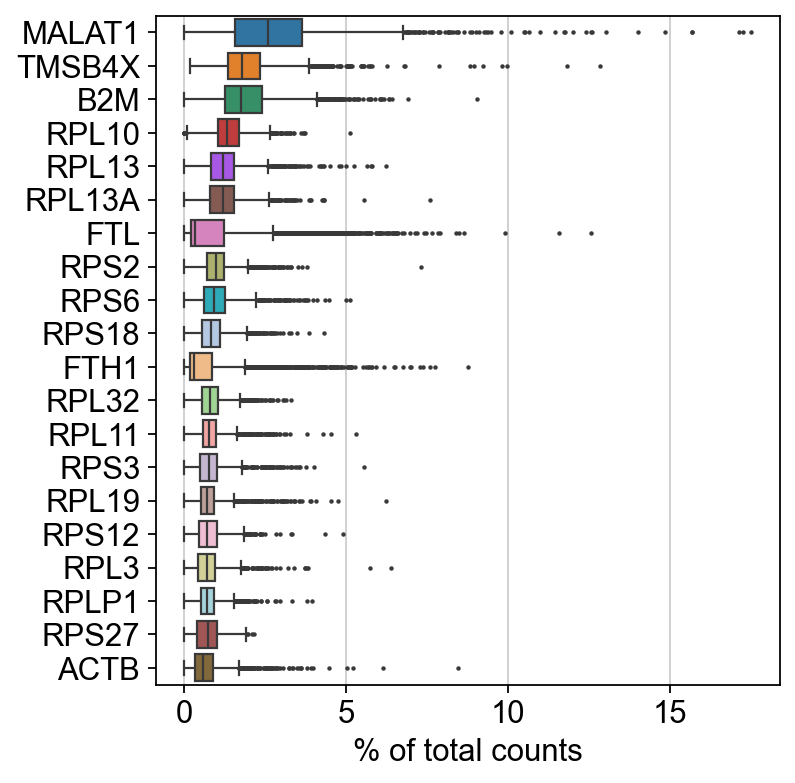

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Note that MALAT1, a non-coding RNA that is known to be extremely abundant in many cells, ranks at the top.

## Basic filtering: remove cells and genes with low expression or missing values.

Here, the first command gets ride of the cells with fewer than 200 genes, and the next command gets rid of the genes that are found in fewer than 3 cells. 

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


## Check mitochondrial genes for Quality Control

Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


We can track the group of mitochondrial genes using the following :

In [12]:

adata.var[adata.var.mt == True]

,gene_ids,n_cells,mt
MT-ND1,ENSG00000198888,2558,True
MT-ND2,ENSG00000198763,2416,True
MT-CO1,ENSG00000198804,2686,True
MT-CO2,ENSG00000198712,2460,True
MT-ATP8,ENSG00000228253,32,True
MT-ATP6,ENSG00000198899,2014,True
MT-CO3,ENSG00000198938,2647,True
MT-ND3,ENSG00000198840,557,True
MT-ND4L,ENSG00000212907,398,True
MT-ND4,ENSG00000198886,2588,True


In [13]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

You can check with adata.obs, that a few more columns have been added. 

In [14]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

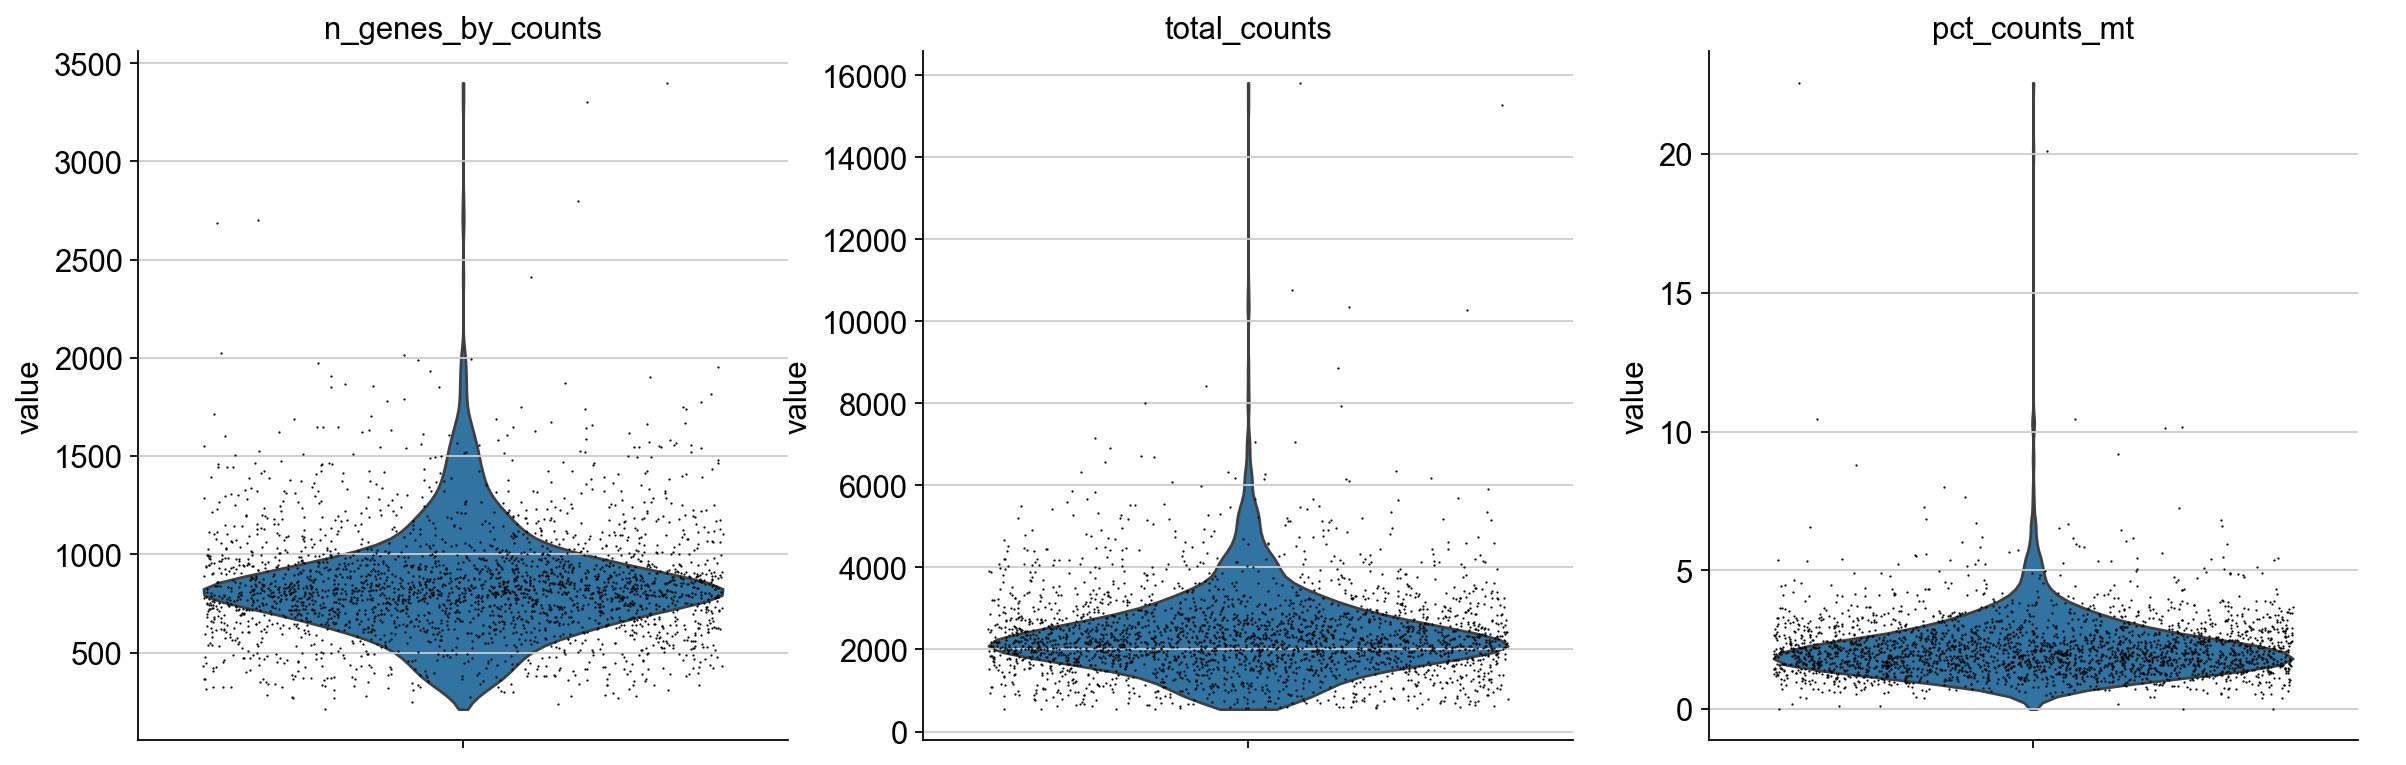

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts. High proportions of mitochondrial genes indicate poor-quality cells, potentially because of loss of cytoplasmic RNA from perforated cells.

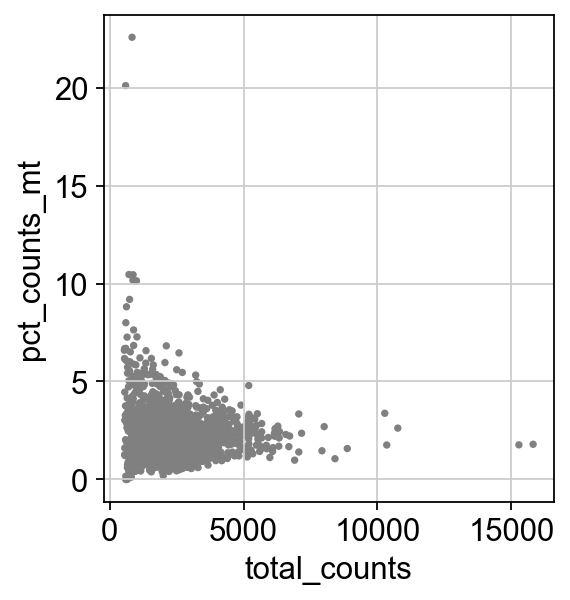

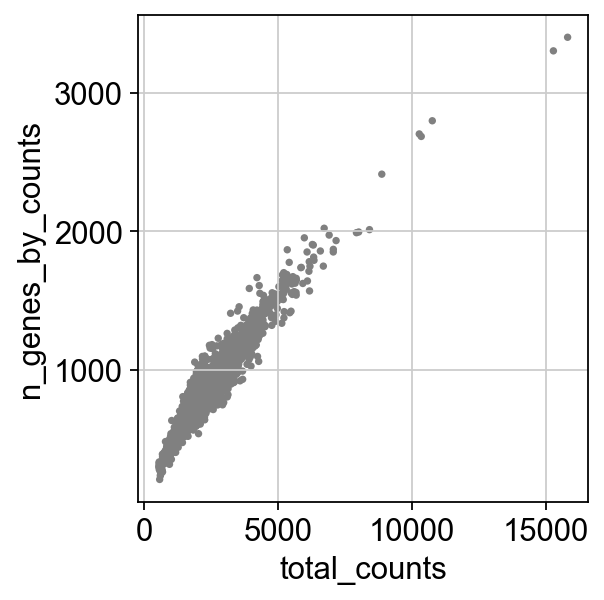

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Filter data based on QC
Check current datset and filter it by slicing the AnnData object.

In [17]:
print(adata)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [18]:
# slice the adata object so you only keep genes and cells that pass the QC
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print(adata)

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


## Data normalization
To correct differences in library sizes across cells, normalize the total read count of the data matrix to 10,000 reads per cell so that counts become comparable among cells.

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/anaconda3/envs/dc_new/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Log transform the data for later use in differential gene expression as well as in visualizations. The natural logarithm is used, and `log1p` means that an extra read is added to cells of the count matrix as a pseudo-read. See [here](https://www.biogazelle.com/seven-tips-bio-statistical-analysis-gene-expression-data) for more information on why log scale makes more sense for genomic data. 

In [20]:
sc.pp.log1p(adata)

## Identify highly-variable genes.
The function `sc.pp.highly_variable_genes` can detect marker genes that can help us identify cells based on a few manually set parameters, including mininum mean expression, maximum mean expression, and minimum dispersion. We will focus our analysis on such genes. 

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


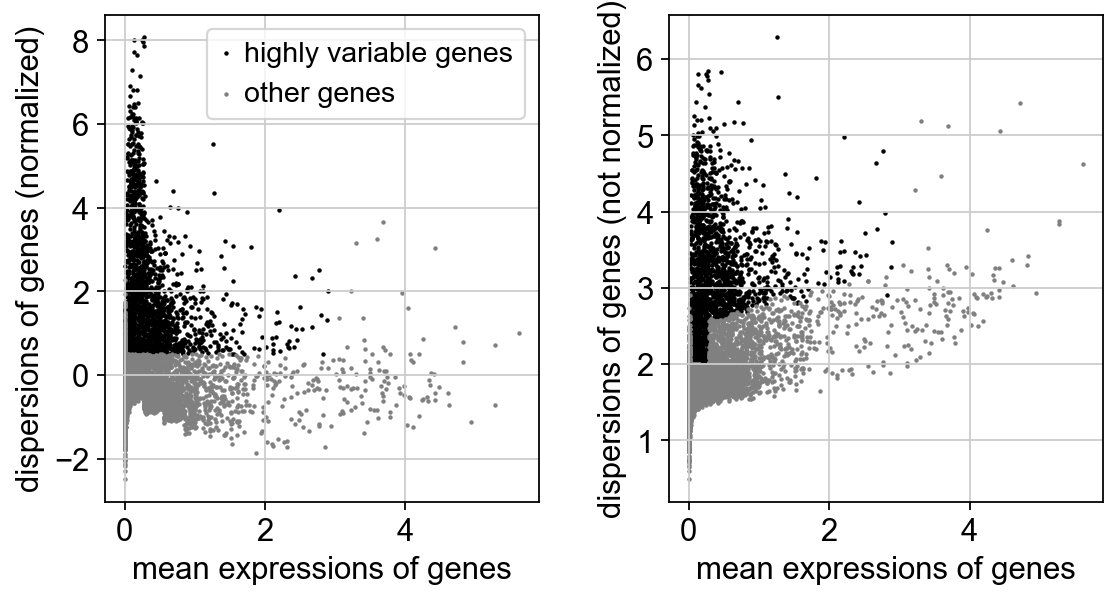

In [22]:
# visualize the highly variable genes with a plot 
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [23]:
adata.raw = adata

Filter the `adata` object so that only genes that are highly variable are kept.

In [24]:
adata = adata[:, adata.var.highly_variable]

## Correct for the effects of counts per cell and mitochondrial gene expression

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. This can consume some memory and take some time because the input data is sparse. 

In [25]:
sc.pp.regress_out(adata, ['n_genes_by_counts', 'pct_counts_mt'])

regressing out ['n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)


/opt/anaconda3/envs/dc_new/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Center the data to zero and scale to unit variance

Use `sc.pp.scale` to center the average expression per gene to zero. Here we are also clipping scaled values that exceed standard deviation of 10.

In [26]:
sc.pp.scale(adata, max_value=10)

## Dimension reduction with PCA

We first use principal component analysis (PCA), a linear dimention-reduction technique, to reveal the main axes of variation and denoise the data.

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

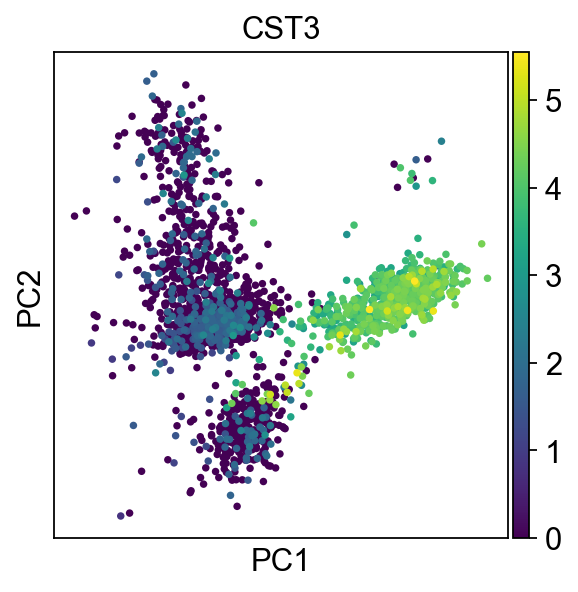

In [28]:
sc.pl.pca(adata, color="CST3")

The variance ratio plot lists contributions of individual principal components (PC) to the total variance in the data. This piece of information helps us to choose an appropriate number of PCs in order to compute the neighborhood relationships between the cells, for instance, using the clustering method Louvain `sc.tl.louvain()` or the embedding method tSNE `sc.tl.tsne()` for dimension-reduction.

According to the authors of Scanpy, a rough estimate of the number of PCs does fine.

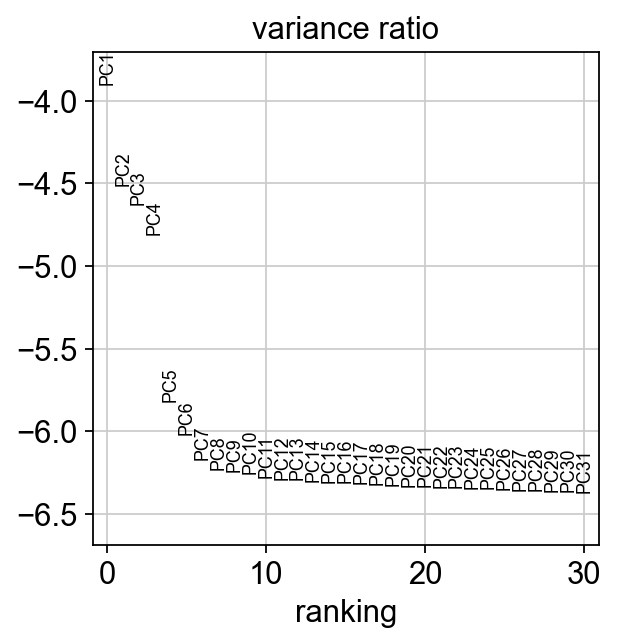

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result up to PCA analysis.

In [30]:
! mkdir -p write
adata.write(results_file)

Note that our adata object has following elements: observations annotation (obs), variables (var), unstructured annotation (uns), multi-dimensional observations annotation (obsm), and multi-dimensional variables annotation (varm). The meanings of these parameters are documented in the anndata package, available at [anndata documentation](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html).

In [31]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing and Embedding the neighborhood graph

Use the PCA representation of the data matrix to compute the neighborhood graph of cells. 
For every single cell in your dataset, this function finds its "neighbors" i.e the other cells that have the most similar patterns of gene expression.
Instead of comparing cells based on all 1,838 genes, we use the top 40 principal components from the earlier PCA step.

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


The auhours of Scanpy suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)).
UMAP is a non-linear dimension reduction algorithm, which seeks to learn the manifold structure of the data, and tries to find a low dimensional embedding that preserves the essential topological structure of that manifold. In simple terms, it projects high-dimensional data onto a 2D plot while preserving the essential relationships and topology of the original space as faithfully as possible.
It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. 

In [33]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


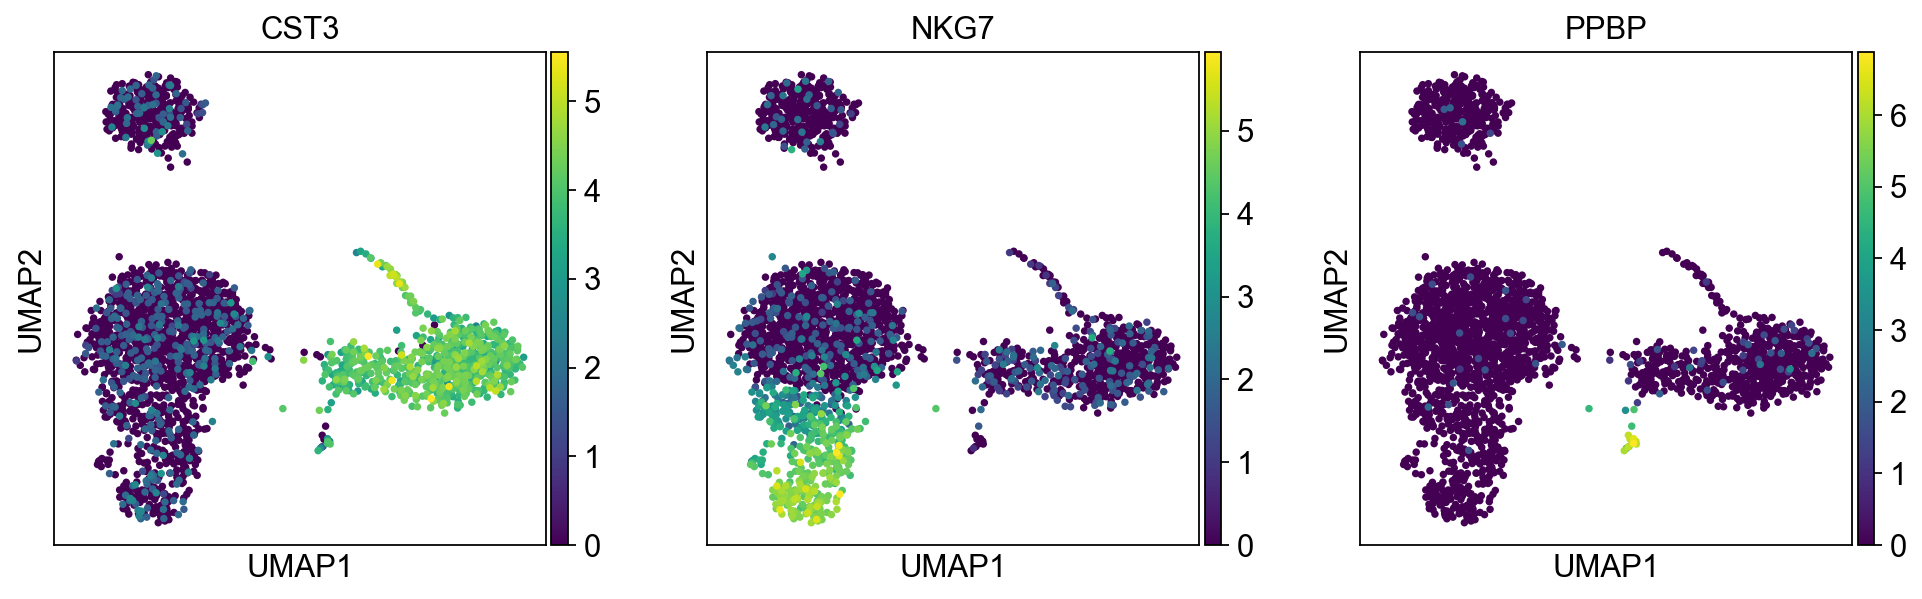

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use `.raw`.

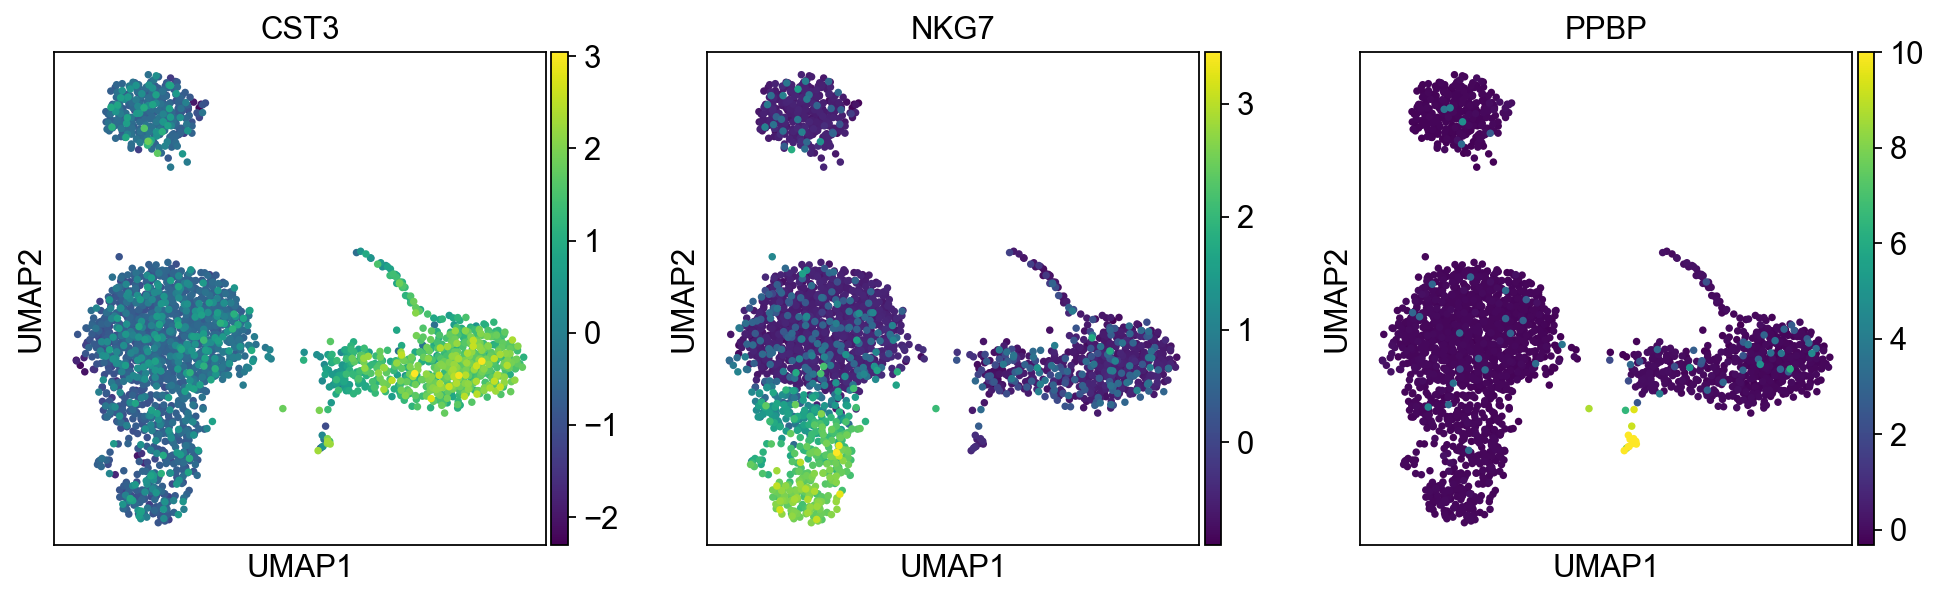

In [35]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://arxiv.org/abs/1810.08473). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section. Compared with the Louvain algorithm, the Leiden algorithm yields communities that are guaranteed to be connected. When applied iteratively, the Leiden algorithm converges to a partition in which all subsets of all communicities are locally optimally assigned. Last but not least, it runs faster.

In [36]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/var/folders/rr/24f28zy54p19m85qmq5k28jr0000gn/T/ipykernel_12810/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Plot the clusters using `sc.pl.umap`. Note that the color parameter accepts both individual genes and the clustering method (leiden in this case).

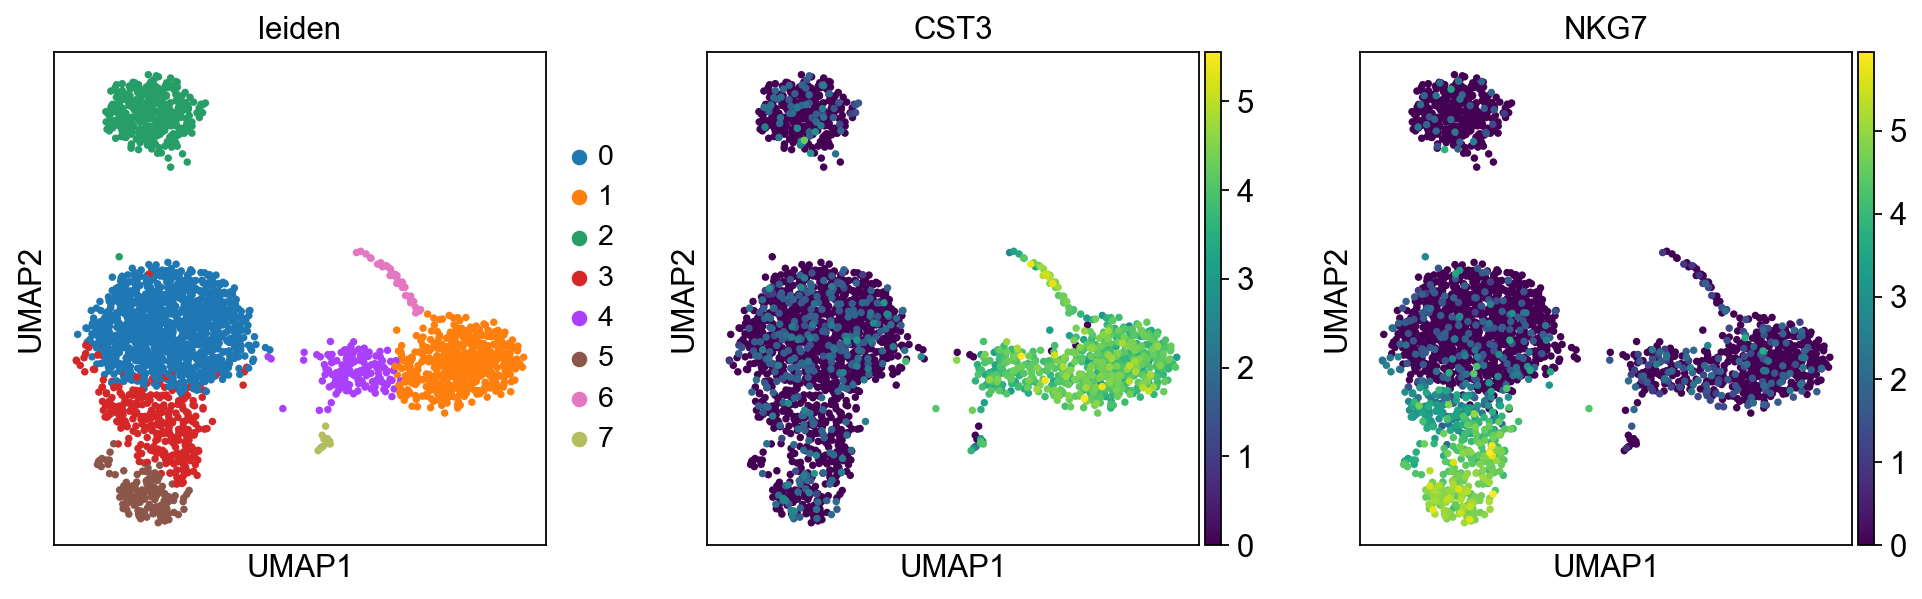

In [37]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

We save the result again.

In [38]:
adata.write(results_file)

In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running the next cell.

In [39]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


## Identifying marker genes

Compute a ranking for the highly differential genes in each cluster. This means we want to create a list for each cell cluster, ordered from the most significant marker gene to the least. This helps us answer the question: "Which genes best define this group of cells?"

For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. To prove a gene is a marker, we can't just say it "looks" higher. We need a statistical test to show that the difference in its expression is mathematically significant. The simplest and fastest method to do so is the t-test. Other methods include Wilcoxon rank-sum (Mann-Whitney-U) test, MAST, limma, DESeq2, and diffxpy by the Theis lab. The authours of Scanpy reccomend using the Wilcoxon rank-sum test in publications.


## The Wilcoxon's test

For simplicity, we start with the Mann-Whitney-U test. The null hypothesis is that the rank of a gene in a cluster is the same as its rank in all cells. The alternative hypothesis is that the rank of a gene in a cluster is much higher than its rank in all cells (one-sided). The function `sc.tl.rank_genes_groups` performs the test, and `sc.pl.rank_genes_groups` plots the top genes.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


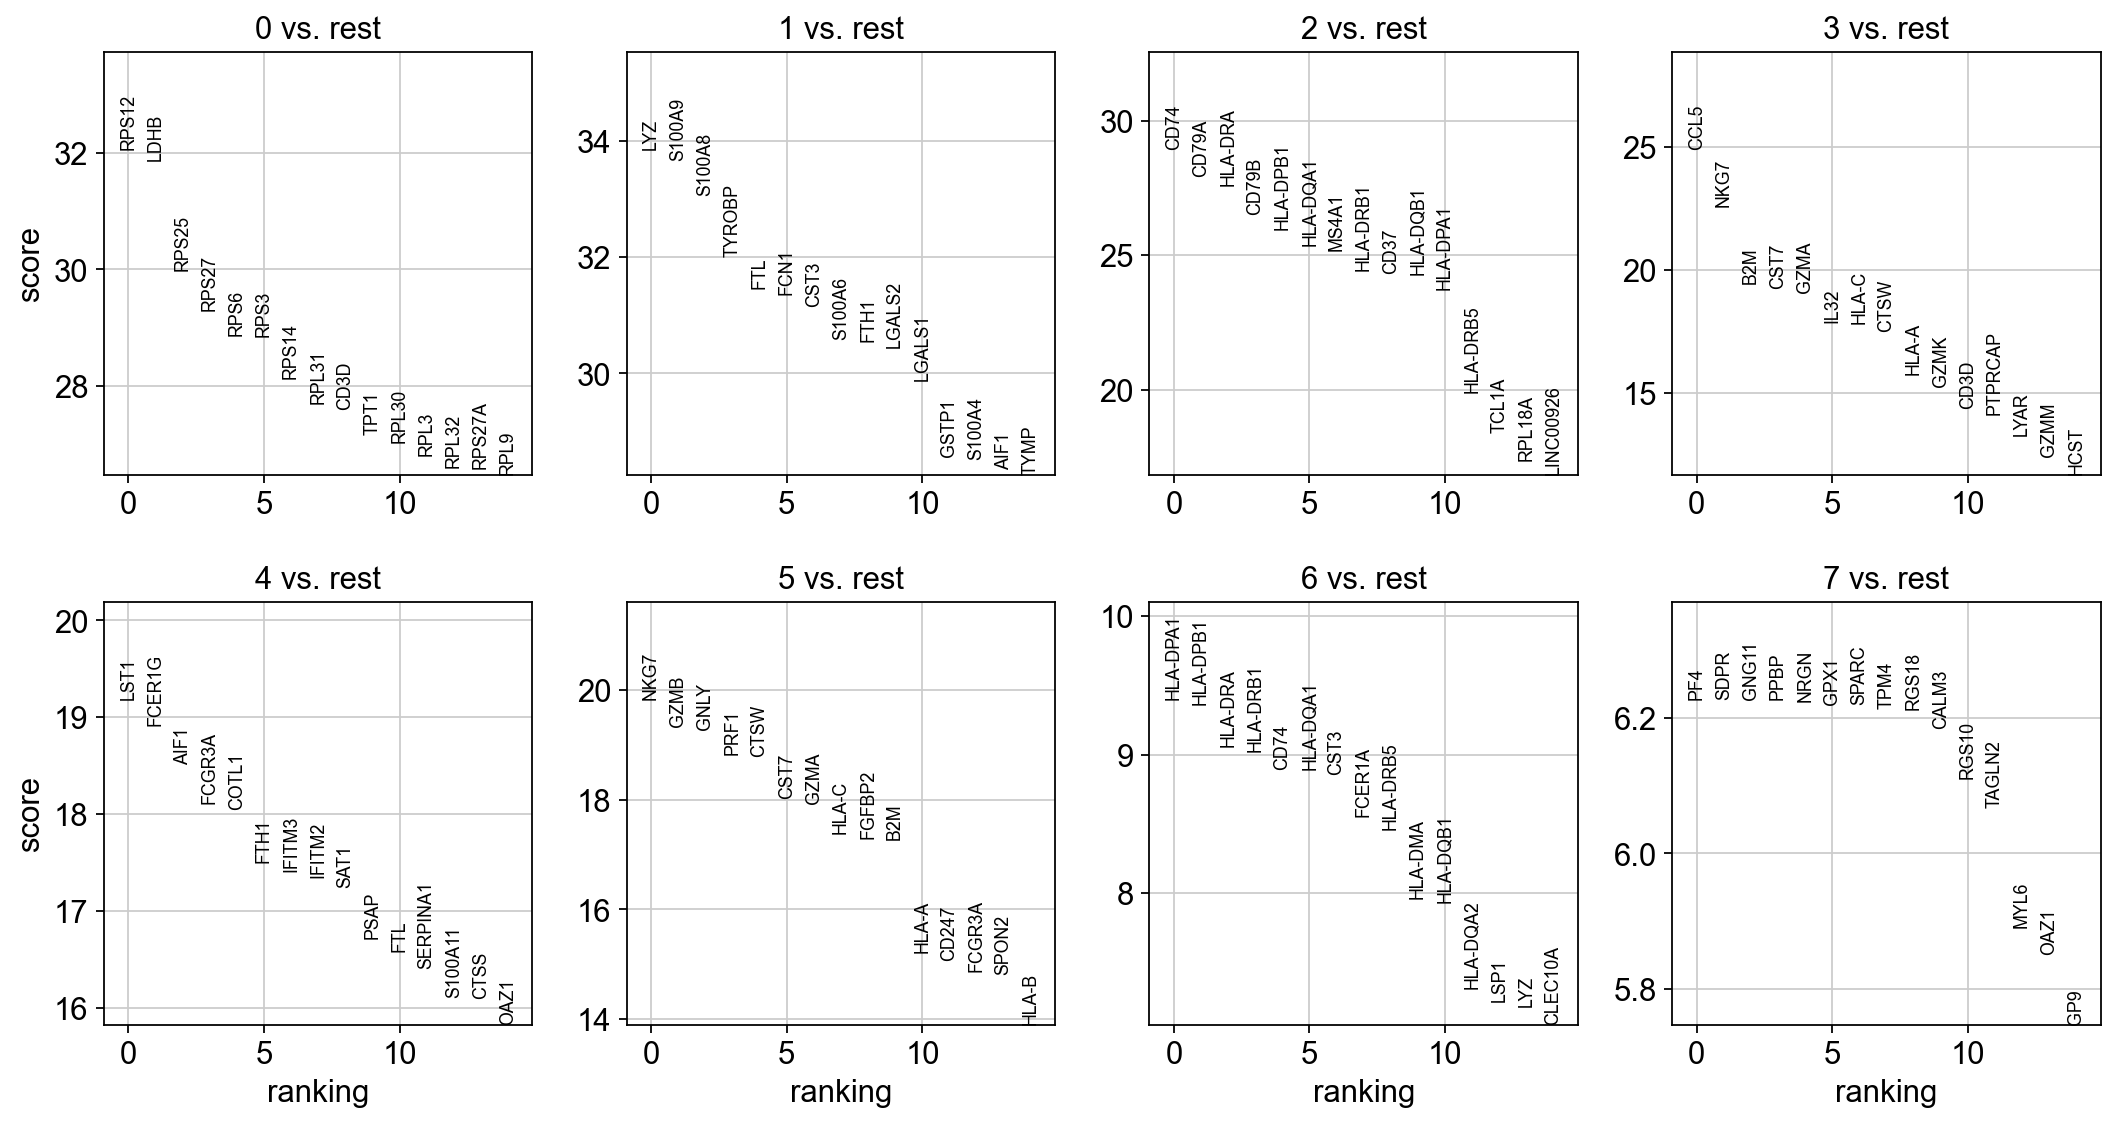

In [40]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [41]:
sc.settings.verbosity = 2  # reduce the verbosity

In [42]:
adata.write(results_file) # write the output to the results file 

## The Student's t-test

An alternative to the non-parametric Wilcoxon test is the t-test.

ranking genes
    finished (0:00:00)


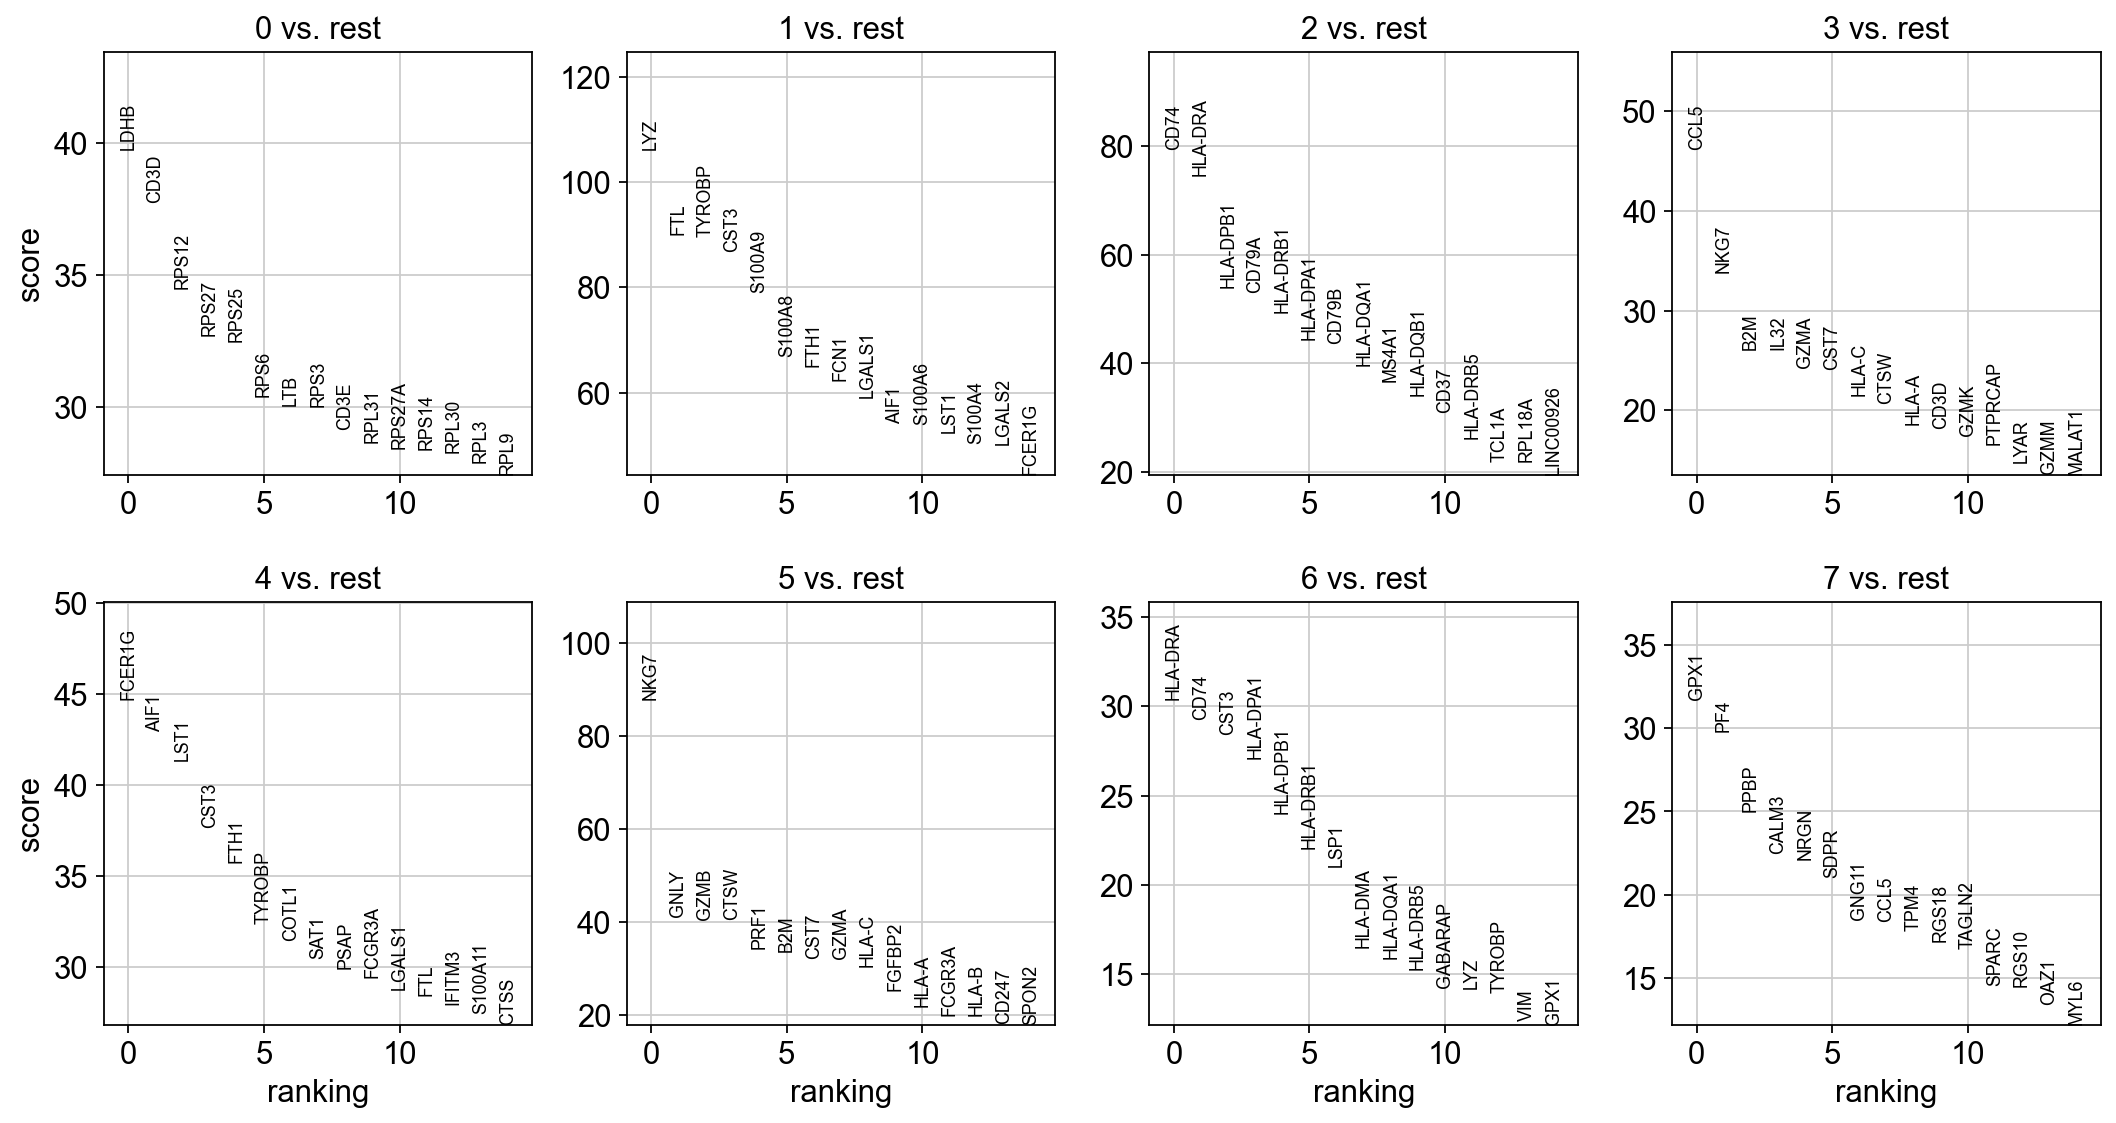

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
    finished (0:00:01)


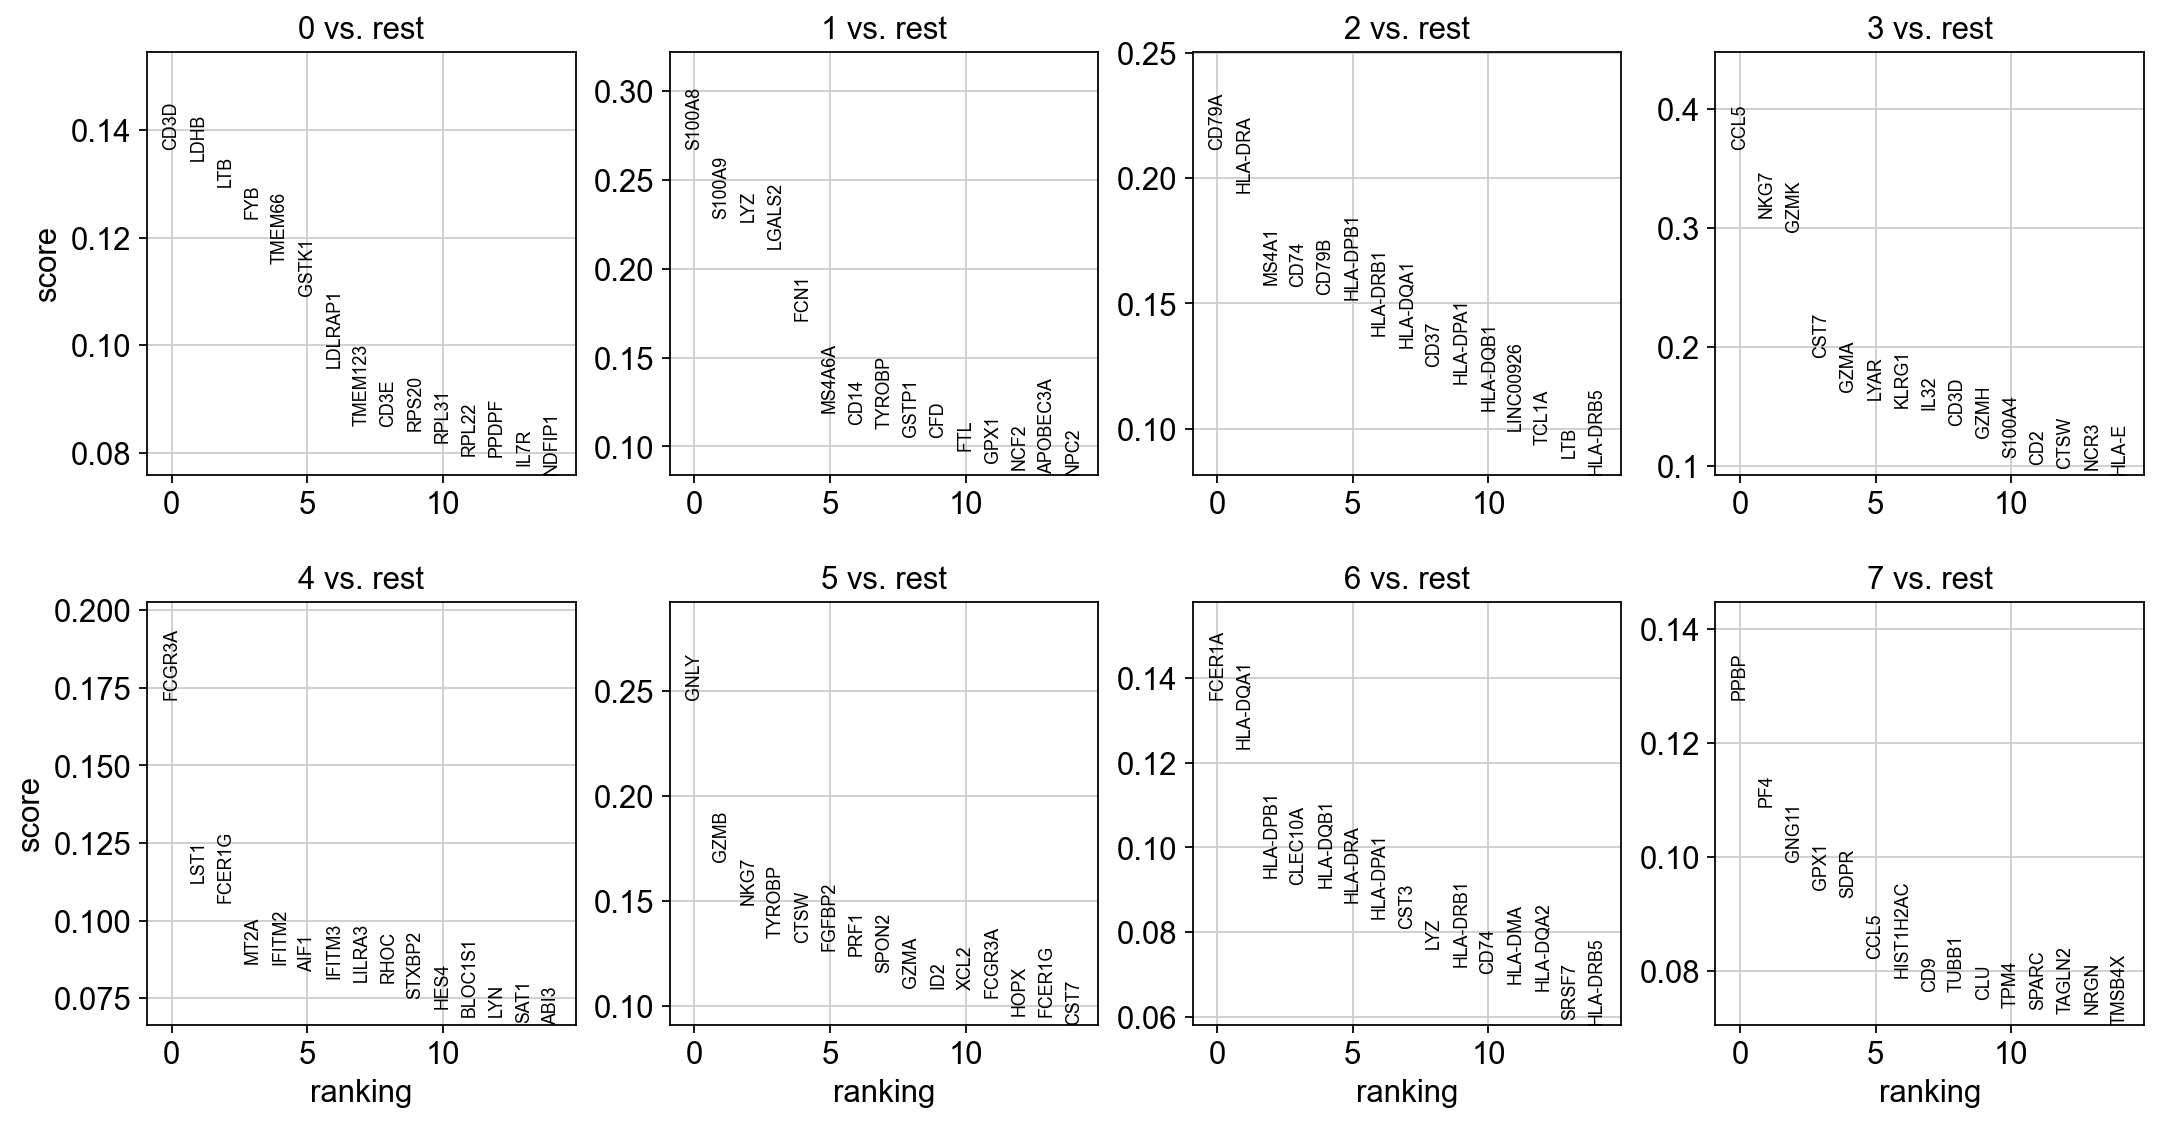

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', method="logreg")
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

Let us also define a list of marker genes for later reference.

In [45]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

## Listing signatures using the results of the Wilcoxon's test

We use the results of the Wilcoxon's test for downstream analysis. Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [46]:
adata = sc.read(results_file)

In [47]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [48]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,FCER1G,GZMB,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GNLY,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,FCGR3A,PRF1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,COTL1,CTSW,CD74,NRGN


Get a table with the scores and groups.

In [49]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.576558e-225,LYZ,3.549440e-251,CD74,5.152737e-184,CCL5,8.753282e-137,LST1,4.811679e-82,NKG7,1.427704e-87,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,6.965907e-223,S100A9,2.457938e-248,CD79A,1.345644e-171,NKG7,8.635824e-113,FCER1G,8.904783e-80,GZMB,2.668151e-83,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,2.058791e-197,S100A8,9.395211e-240,HLA-DRA,1.154525e-167,B2M,2.647369e-84,AIF1,1.511589e-76,GNLY,6.948432e-83,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,1.236058e-188,TYROBP,5.842957e-225,CD79B,5.366334e-155,CST7,1.580896e-82,FCGR3A,2.936254e-73,PRF1,4.659871e-79,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,2.504379e-183,FTL,2.349223e-217,HLA-DPB1,1.153077e-148,GZMA,2.510146e-81,COTL1,7.797082e-73,CTSW,8.466720e-79,CD74,5.853161e-19,NRGN,4.800511e-10


Compare to a single cluster:

ranking genes
    finished (0:00:00)


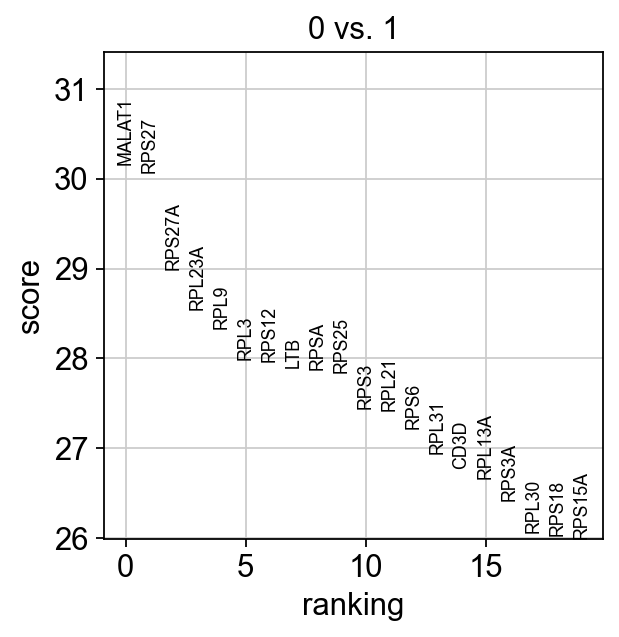

In [50]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/opt/anaconda3/envs/dc_new/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


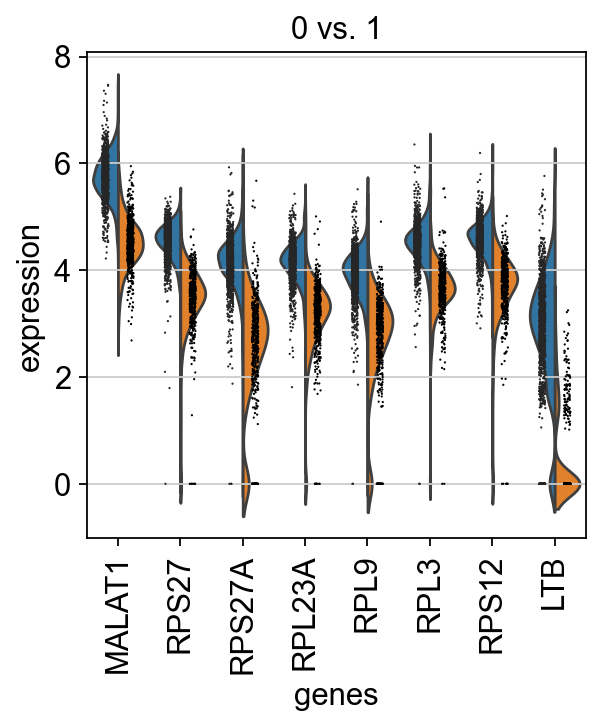

In [51]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

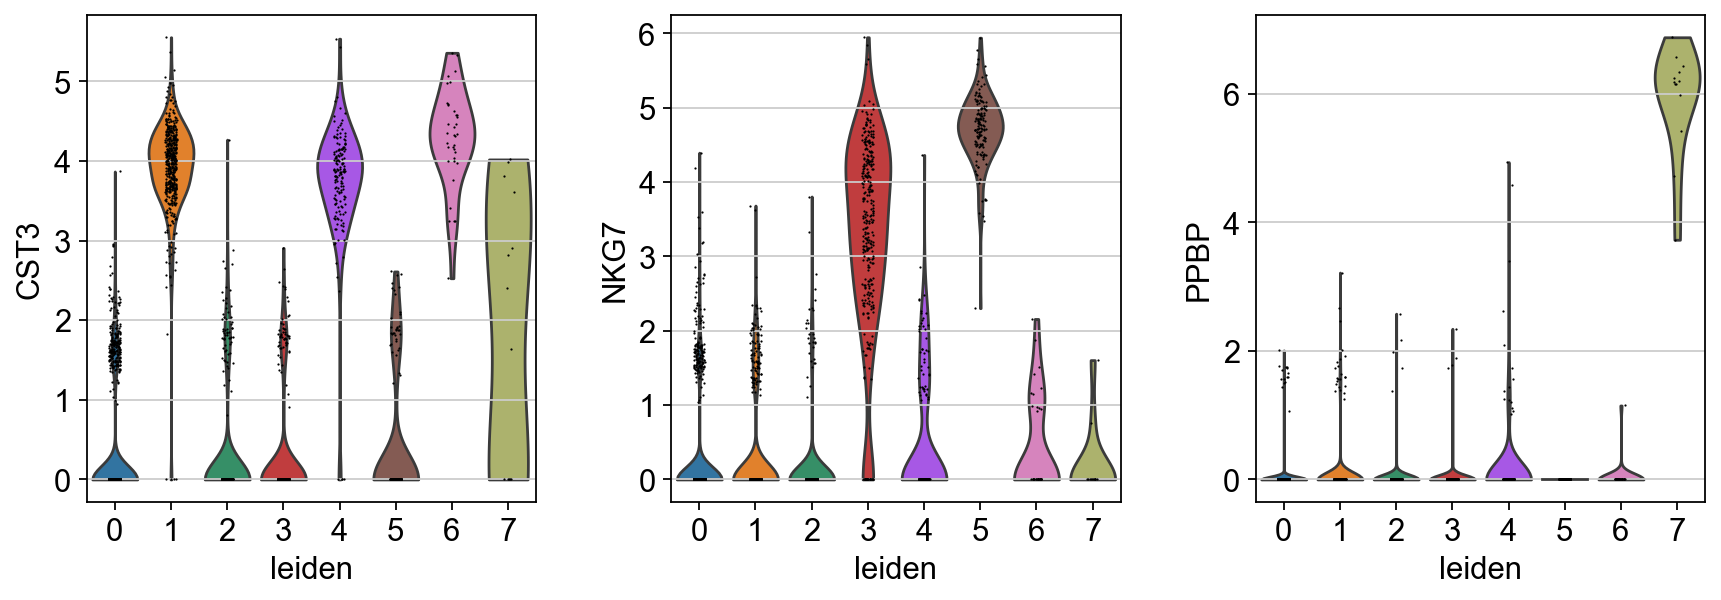

In [52]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types. The old, numeric cluster labels from the 'leiden' clustering result (0, 1, 2,...) is replaced with the new, descriptive biological names.

In [53]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)


Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


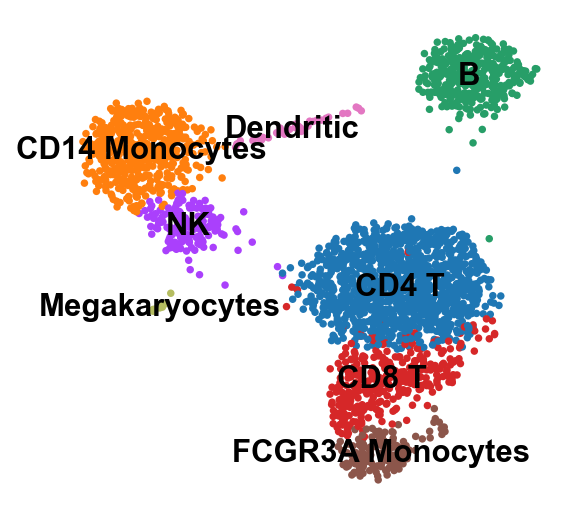

In [54]:
# plot the UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

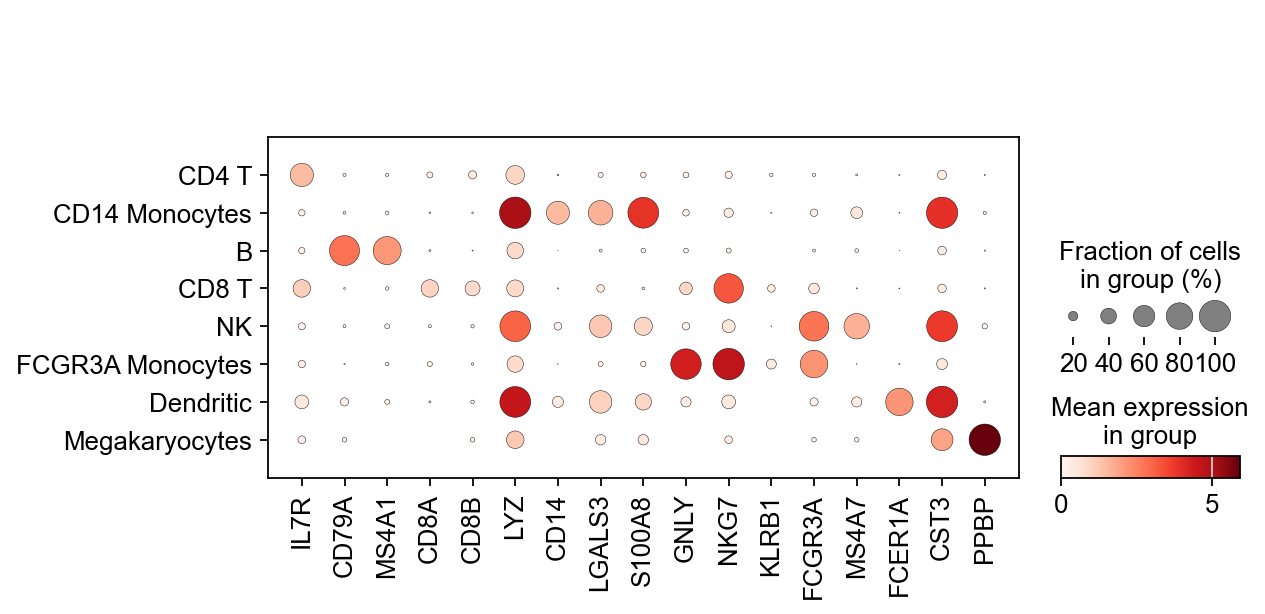

In [55]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

There is also a very compact violin plot.

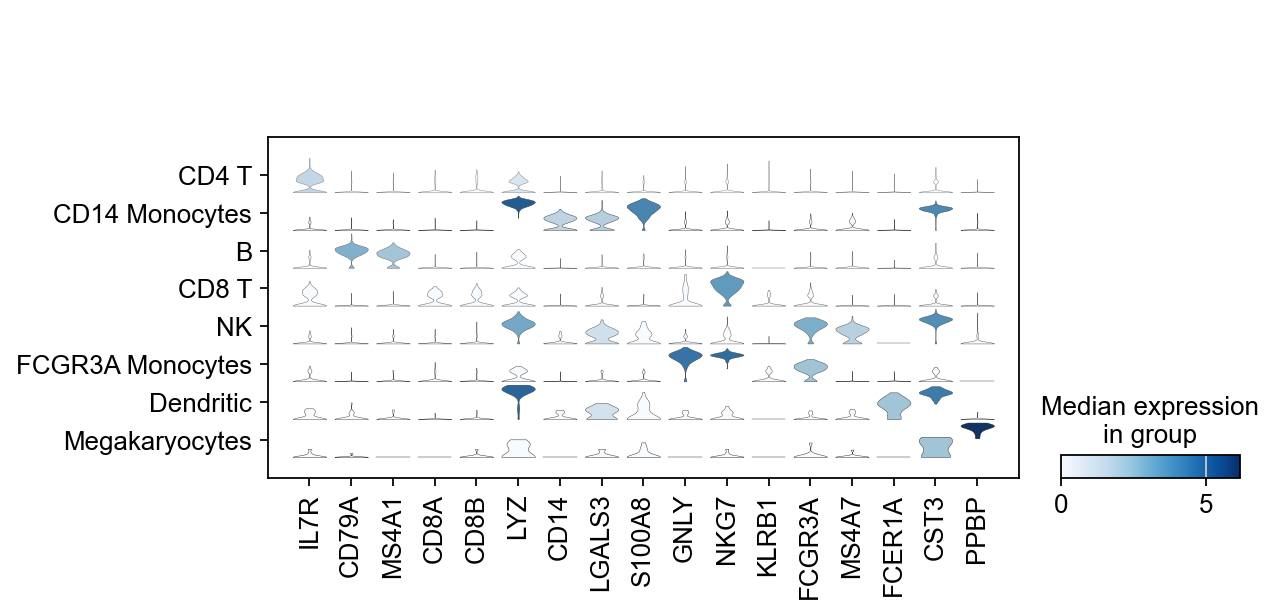

In [56]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', var_group_rotation=90)

During the course of this analysis, the AnnData accumulated the following annotations.

In [57]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

If you want to save your results:

In [58]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using h5ls, which has many options - for more details see here. The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [59]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to “csv”, you have the following options:

In [60]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

# Using DeepChem with ScanPy

We can also use DeepChem after the above feature engineering with ScanPy to make further inferences. Here is a simple demonstration on making a DeepChem Dataset using the above adata.
Deepchem datasets have the attribute 'ids' that can store the identifiers of the data samples. It can be used to store the unique cell barcodes (unique identifiers for each cell captured during a single-cell RNA sequencing (scRNA-seq) experiment). adata.obs, which stores the annotations for observations contain this barcode.



In [61]:
dataset = dc.data.NumpyDataset(X=adata.X, ids=adata.obs.index.to_numpy())

Now, let's train a model using deepchem to perform cell type identification using the gene expression counts as features.
The following dictionary is to convert cell type labels from strings to integers to be compatible with loss functions.

In [63]:
str_to_int = {
    'CD4 T':0,
    'CD14 Monocytes':1,
    'B':2,
    'CD8 T':3,
    'NK':4,
    'FCGR3A Monocytes':5,
    'Dendritic':6, 
    'Megakaryocytes':7}

n_types = len(str_to_int)

In [64]:
adata.obs['cell_type'] = adata.obs['leiden'].map(str_to_int).astype('category')

Deepchem expects the labels to be of shape (n_samples,n_tasks). As we are performing only one task (cell type identification), let's reshpape it to (n_samples,1).

In [68]:
labels = adata.obs['cell_type'].to_numpy().reshape(-1,1)

In [69]:
dataset = dc.data.NumpyDataset(X=adata.X, ids=adata.obs.index.to_numpy(), y=labels)

The data can be split into train and test set using Deepchem's data splitters

In [78]:
splitter = dc.splits.SingletaskStratifiedSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset)

To identify the cell types, let's define a custom Deepchem Model class which uses a multi layer perceptron for classification

In [79]:
import torch.nn as nn
import torch.nn.functional as F
from deepchem.models.torch_models import TorchModel
from deepchem.models.losses import SparseSoftmaxCrossEntropy
from deepchem.models.optimizers import Adam
from deepchem.models.optimizers import ExponentialDecay
from deepchem.metrics import from_one_hot
import matplotlib.pyplot as plt


class Classifier(nn.Module):

    def __init__(self, output_dim=None, input_size=None):

        if output_dim == None or input_size == None:
            raise ValueError('Must explicitly declare input dim (num features) and output dim (number of classes)')

        super(Classifier, self).__init__()
        self.inp_dim = input_size
        self.out_dim = output_dim

        # feed forward layers
        self.classifier = nn.Sequential(
                                        nn.Linear(self.inp_dim, 100),
                                        nn.ReLU(),
                                        
                                        nn.Linear(100, 50),
                                        nn.ReLU(),

                                        nn.Linear(50, 25),
                                        nn.ReLU(),

                                        nn.Linear(25, output_dim)
                                        )

    def forward(self, x):
        """
        Forward pass of the classifier
        """
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        predictions = from_one_hot(probabilities.cpu().detach(), axis=1)
        return (predictions, logits)
    

class Classifier_Model(TorchModel):
    def __init__(self, output_dim = None, input_size = None, **kwargs):

        self.model = Classifier(output_dim=output_dim, input_size=input_size)
        self.criterion = SparseSoftmaxCrossEntropy()
        cf_optimizer = Adam(learning_rate=0.0001,
                            beta1=0.9,
                            beta2=0.999,
                            epsilon=1e-08,
                            weight_decay=0.005,
                            )

        cf_decayRate = 0.95
        cf_lr_scheduler = ExponentialDecay(initial_rate=0.0001, decay_rate=cf_decayRate, decay_steps=1000)
        super(Classifier_Model,
              self).__init__(self.model,
                             loss=self.criterion,
                             optimizer=cf_optimizer,
                             learning_rate=cf_lr_scheduler,
                             output_types=['prediction', 'loss'],
                             **kwargs)

To create an object for the Model class

In [ ]:
model = Classifier_Model(output_dim=n_types, input_size= dataset.X.shape[1])

Let's train the model. 
The fit method in DeepChem outputs the mean loss over the entire dataset for an epoch, which can then be used to construct a training loss curve.

Epoch 1/15, Loss: 1.9160809950395064
Epoch 2/15, Loss: 1.869557640769265
Epoch 3/15, Loss: 1.7975677143443713
Epoch 4/15, Loss: 1.687332500110973
Epoch 5/15, Loss: 1.4191647529602052
Epoch 6/15, Loss: 1.3795875202525745
Epoch 7/15, Loss: 1.2089317495172673
Epoch 8/15, Loss: 1.0259382941506126
Epoch 9/15, Loss: 0.8503541079434481
Epoch 10/15, Loss: 0.7023157596588134
Epoch 11/15, Loss: 0.6162557601928711
Epoch 12/15, Loss: 0.5443707812916149
Epoch 13/15, Loss: 0.4824871149930087
Epoch 14/15, Loss: 0.37415534257888794
Epoch 15/15, Loss: 0.3686625740744851


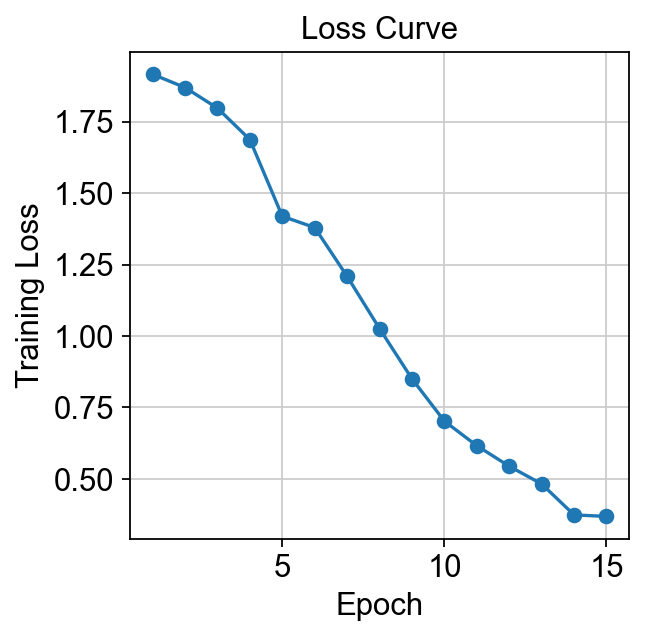

In [ ]:

classification_metric = dc.metrics.Metric(dc.metrics.accuracy_score)

nb_epoch = 15
losses = []
for epoch in range(nb_epoch):
    loss = model.fit(train_dataset, nb_epoch=1)
    losses.append(loss)
    print(f"Epoch {epoch+1}/{nb_epoch}, Loss: {loss}")

# Plot loss curve
plt.plot(range(1, nb_epoch+1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.show()

Now let's make predictions on the test dataset

In [81]:
predictions = model.predict(test_dataset)

Let's evaluate the predictions using accuracy score

In [82]:
scores = model.evaluate(test_dataset, [classification_metric], n_classes=n_types)

In [83]:
print(scores['accuracy_score'])

0.876425855513308


More about cell type identification can be found in a dedicated [tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Cell_type_identification_using_scRNAseq_data.ipynb) on Deepchem.

## References

1. anndata: Annotated data.Isaac Virshup, Sergei Rybakov, Fabian J. Theis, Philipp Angerer, F. Alexander Wolf. JOSS 2024 Sep 16. doi: 10.21105/joss.04371.
Docs: https://anndata.readthedocs.io/en/stable/
2. SCANPY: large-scale single-cell gene expression data analysis. F. Alexander Wolf, Philipp Angerer, Fabian J. Theis. Genome Biology 2018 Feb 06. doi: 10.1186/s13059-017-1382-0. 
Docs: https://scanpy.readthedocs.io/en/stable/

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

In [ ]:
@manual {Bioinformatics,
 title={Scanpy},
 organization={DeepChem},
 author={Paiz, Paulina and Adithya, Harindhar and Singh, Rakshit kr. and Ramsundar, Bharath},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Scanpy.ipynb}},
 year={2025},
}